In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/nsduh_sample.csv')
print("Shape:", df.shape)
df.head()

Shape: (10000, 6)


,age,gender,income,education,mental_health,drug_use
0,56,0,81407,3,0,0
1,46,0,73821,4,0,0
2,32,1,55690,1,0,0
3,60,0,26654,2,0,0
4,25,0,87557,3,0,0


In [2]:
df.info()
print(df.isnull().sum())
target_col = 'drug_use'
print(df[target_col].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age            10000 non-null  int64
 1   gender         10000 non-null  int64
 2   income         10000 non-null  int64
 3   education      10000 non-null  int64
 4   mental_health  10000 non-null  int64
 5   drug_use       10000 non-null  int64
dtypes: int64(6)
memory usage: 468.9 KB
age              0
gender           0
income           0
education        0
mental_health    0
drug_use         0
dtype: int64
drug_use
0    8702
1    1298
Name: count, dtype: int64


In [3]:
df = df.dropna(subset=[target_col])
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

In [4]:
X = df.drop(target_col, axis=1)
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [7]:
lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

xgb = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
y_prob_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

In [8]:
results = pd.DataFrame({
    'Model': ['LR', 'RF', 'XGB'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb)],
    'AUC-ROC': [roc_auc_score(y_test, y_prob_lr), roc_auc_score(y_test, y_prob_rf), roc_auc_score(y_test, y_prob_xgb)]
})
print(results)

  Model  Accuracy   AUC-ROC
0    LR    0.8445  0.939819
1    RF    0.8930  0.946202
2   XGB    0.8645  0.944309


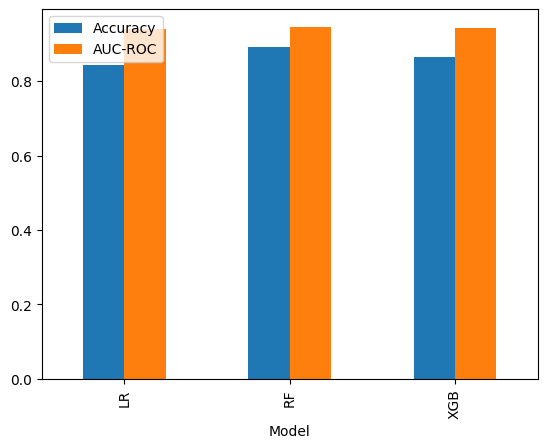

In [9]:
results.set_index('Model')[['Accuracy', 'AUC-ROC']].plot(kind='bar')
plt.show()

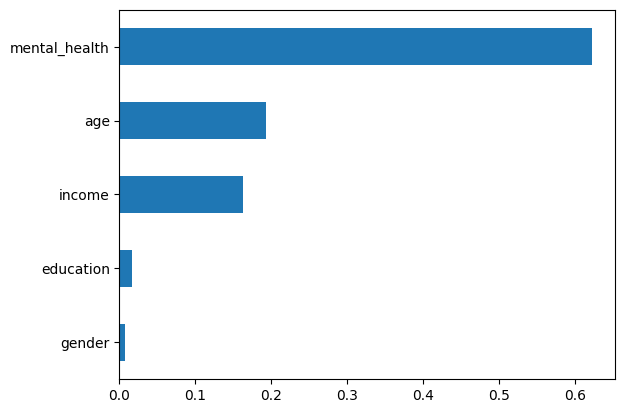

In [10]:
pd.Series(rf.feature_importances_, index=X.columns).sort_values().tail(10).plot(kind='barh')
plt.show()

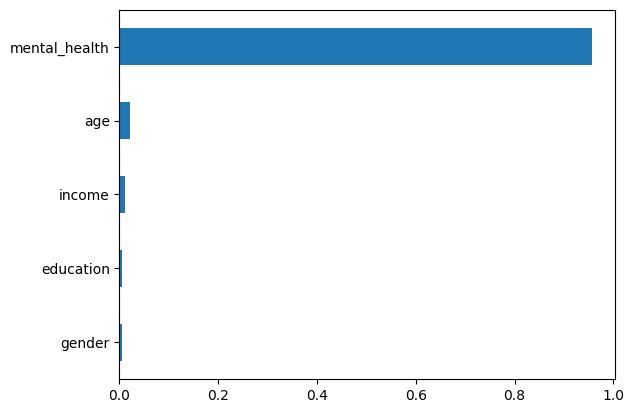

In [11]:
pd.Series(xgb.feature_importances_, index=X.columns).sort_values().tail(10).plot(kind='barh')
plt.show()

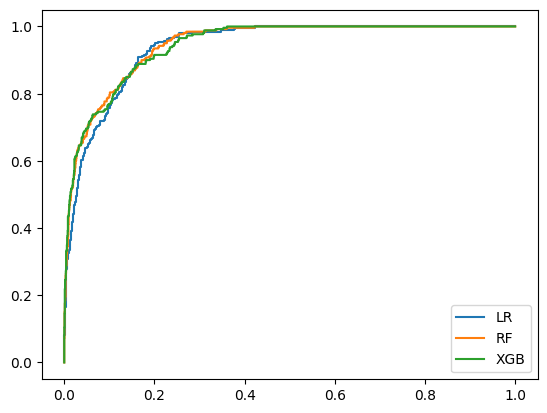

Best Model: XGB


In [12]:
from sklearn.metrics import roc_curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_xgb, tpr_xgb, label='XGB')
plt.legend()
plt.show()
print("Best Model: XGB")

In [5]:
import joblib
joblib.dump(lr, '../models/lr_model.pkl')
joblib.dump(rf, '../models/rf_model.pkl')
joblib.dump(xgb, '../models/xgb_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

NameError: name 'rf' is not defined